In [18]:
import pandas as pd
from requests.packages import target

abstracts = pd.read_csv('data/abstracts.txt', sep=r'\|\-\-\|', header=None, index_col=False, engine='python')
abstracts.columns = ['paper_id', 'abstracts']
abstracts['abstracts'] = abstracts['abstracts'].fillna('')
positive_edges = pd.read_csv('data/edgelist.txt', sep=',', header=None)
positive_edges.columns = ['source', 'target']

In [20]:

import nltk
from nltk.corpus import stopwords
import string
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

#create a tfidf model
from sklearn.feature_extraction.text import TfidfVectorizer

abstracts['abstracts'] = abstracts['abstracts'].apply(remove_stopwords)
tfidf = TfidfVectorizer(max_features=1000, stop_words='english', lowercase=True)
tfidf_matrix = tfidf.fit_transform(abstracts['abstracts'])
print(tfidf_matrix)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5436930 stored elements and shape (138499, 1000)>
  Coords	Values
  (0, 239)	0.14873335949036237
  (0, 68)	0.16114746478949796
  (0, 713)	0.22258880386385235
  (0, 61)	0.13707230794762892
  (0, 678)	0.2319656847076964
  (0, 434)	0.3225974391328858
  (0, 809)	0.16254822507148892
  (0, 435)	0.08888811015889338
  (0, 597)	0.1675818407703469
  (0, 560)	0.15530881377011604
  (0, 956)	0.15467553229387088
  (0, 545)	0.16232855067600066
  (0, 201)	0.19135297658373182
  (0, 618)	0.1028959212783044
  (0, 661)	0.3254755347205564
  (0, 619)	0.3357969385902007
  (0, 95)	0.2709139195721725
  (0, 653)	0.15020855818674675
  (0, 510)	0.12587882674966358
  (0, 305)	0.1261688590720433
  (0, 965)	0.1350271414299269
  (0, 470)	0.16367063029627346
  (0, 401)	0.09827105246815493
  (0, 139)	0.10164248722687064
  (0, 322)	0.15527145493330044
  :	:
  (138498, 114)	0.08931782935495797
  (138498, 798)	0.10917948322387327
  (138498, 877)	0.1200543600222

In [39]:

from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(row):
    source_abstract = row['source_abstract']
    target_abstract = row['target_abstract']

    # Transform the abstracts into TF-IDF vectors
    tfidf_source = tfidf.transform([source_abstract])
    tfidf_target = tfidf.transform([target_abstract])

    # Compute the cosine similarity between the two TF-IDF vectors
    similarity = cosine_similarity(tfidf_source, tfidf_target)[0][0]

    return similarity

positive_edges['source_abstract'] = positive_edges['source'].map(abstracts.set_index('paper_id')['abstracts'])
positive_edges['target_abstract'] = positive_edges['target'].map(abstracts.set_index('paper_id')['abstracts'])


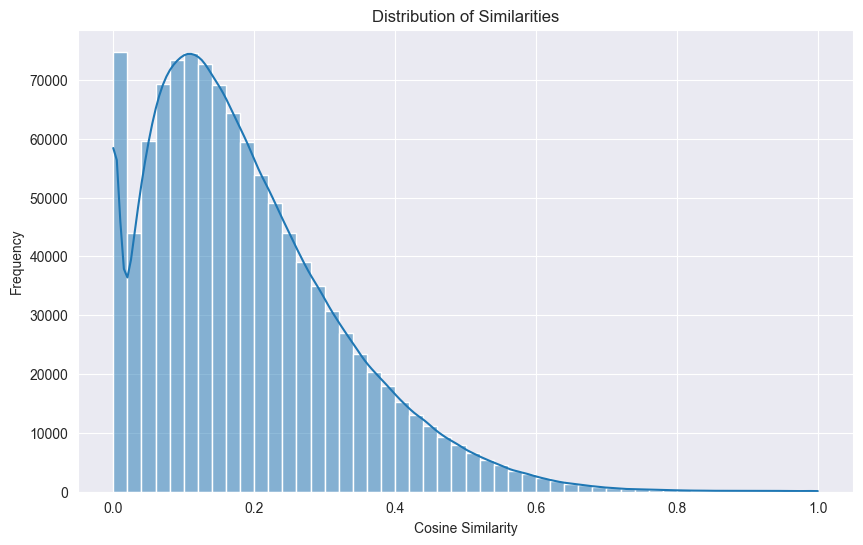

In [40]:

# Apply the function to each row in the DataFrame
positive_edges['similarity'] = positive_edges.apply(get_similarity, axis=1)
#write similarity and row index to a csv file
# Reset the index to include it as a column
#if a similarity is above 1 truncate it to 1
positive_edges['similarity'] = positive_edges['similarity'].clip(upper=1)
edges_to_predict_reset = positive_edges.reset_index()

#plot similarities
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(positive_edges['similarity'], bins=50, kde=True)
plt.title('Distribution of Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.savefig('similarity_distribution.png')
plt.show()

# Save the index and similarity columns to a CSV file
edges_to_predict_reset.to_csv('data/positive_edges_similarities.csv', index=False)